In [9]:
%reload_ext autoreload
%autoreload 2

In [10]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
import openpyxl as xl
from datetime import timedelta
import numpy as np

In [11]:
import sys

sys.path.append("../../../")
from src.model_data_prep import create_outbreak_summary

# LGU Health Data Preparation

In this notebook, we will be aggregating and processing the LGU dengue dataset for one city in preparation for model development. Steps taken are:

1. Filter data to contain only the target city, date range, and disease
2. Get the `start_of_week` date from each `DAdmit` (admission date) from the dataset.
3. Create bins for ages.
4. Attach PSGC codes using string matching.
5. Visualize cases to inspect which features we can aggregate to join for the model development.
6. Define the threshold and labeling each week as outbreak or no outbreak.

At the end, we create an outbreak summary table containing all of the detected outbreak events, start and end date, and length in weeks.

In [12]:
LGU_DIR = Path("../../../data/02-raw/health/LGU/Zamboanga/")
RAW_DIR = Path("../../../data/02-raw/health/")
PROCESSED_DIR = Path("../../../data/03-processed/health/")

ADMIN_BOUNDS = Path("../../../data/01-admin-bounds/target_admin_bounds.shp")

## Load disease outcomes table

In [13]:
# load excel file and check sheet names
cases_df = pd.read_csv(RAW_DIR / "em_pidsr_fhsis.csv")
cases_df = cases_df.drop(columns=["Unnamed: 0"])
cases_df["Date"] = pd.to_datetime(cases_df["Date"])
cases_df.head()

,Source,Year,Month,Week,Date,Region,PSGC_Region,Municipality,PSGC_Municipality,ICD,Disease,Cases,Claims,Deaths,Case_Type,Date_Type
0,PIDSR-DOH,2008.0,1.0,1,2008-01-07,NCR,PH130000000,Mandaluyong City,PH137401000,A00,CHOLERA,0.0,NaN,NaN,Morbidity,Weekly
1,PIDSR-DOH,2008.0,1.0,1,2008-01-07,NCR,PH130000000,Mandaluyong City,PH137401000,A90-A91,"FEVER, DENGUE",NaN,NaN,NaN,Morbidity,Weekly
2,PIDSR-DOH,2008.0,1.0,1,2008-01-07,NCR,PH130000000,Mandaluyong City,PH137401000,A01,"FEVER, TYPHOID",1.0,NaN,NaN,Morbidity,Weekly
3,PIDSR-DOH,2008.0,1.0,1,2008-01-07,NCR,PH130000000,Mandaluyong City,PH137401000,NaN,"GASTROENTERITIS AND COLITIS, INFECTIOUS ORIGIN...",NaN,NaN,NaN,Morbidity,Weekly
4,PIDSR-DOH,2008.0,1.0,1,2008-01-07,NCR,PH130000000,Mandaluyong City,PH137401000,B15,"HEPATITIS, TYPE A, ACUTE",0.0,NaN,NaN,Morbidity,Weekly


## Filter table to specifications

In [14]:
dengue_mask = cases_df["Disease"].str.contains("DENGUE")
pidsr_mask = cases_df["Source"] == "PIDSR-DOH"
dengue_df = cases_df[dengue_mask]
dengue_df

,Source,Year,Month,Week,Date,Region,PSGC_Region,Municipality,PSGC_Municipality,ICD,Disease,Cases,Claims,Deaths,Case_Type,Date_Type
1,PIDSR-DOH,2008.0,1.0,1,2008-01-07,NCR,PH130000000,Mandaluyong City,PH137401000,A90-A91,"FEVER, DENGUE",NaN,NaN,NaN,Morbidity,Weekly
8,PIDSR-DOH,2008.0,1.0,1,2008-01-07,NCR,PH130000000,Muntinlupa City,PH137603000,A90-A91,"FEVER, DENGUE",NaN,NaN,NaN,Morbidity,Weekly
15,PIDSR-DOH,2008.0,1.0,1,2008-01-07,NCR,PH130000000,Navotas City,PH137503000,A90-A91,"FEVER, DENGUE",7.0,NaN,NaN,Morbidity,Weekly
22,PIDSR-DOH,2008.0,1.0,1,2008-01-07,Region I,PH010000000,Dagupan City,PH015518000,A90-A91,"FEVER, DENGUE",NaN,NaN,NaN,Morbidity,Weekly
29,PIDSR-DOH,2008.0,1.0,1,2008-01-07,Region III,PH030000000,Palayan City,PH034919000,A90-A91,"FEVER, DENGUE",1.0,NaN,NaN,Morbidity,Weekly
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74938,FHSIS_Zamboanga,2021.0,9.0,35,2021-08-23,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,"FEVER, DENGUE, HEMORRHAGIC",3.0,NaN,NaN,Morbidity,Monthly
74943,FHSIS_Zamboanga,2021.0,10.0,39,2021-09-20,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,"FEVER, DENGUE, HEMORRHAGIC",0.0,NaN,NaN,Morbidity,Monthly
74948,FHSIS_Zamboanga,2021.0,11.0,44,2021-10-25,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,"FEVER, DENGUE, HEMORRHAGIC",0.0,NaN,NaN,Morbidity,Monthly
74953,FHSIS_Zamboanga,2021.0,12.0,48,2021-11-22,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,"FEVER, DENGUE, HEMORRHAGIC",0.0,NaN,NaN,Morbidity,Monthly


In [15]:
# check if dates are in start of week already
dengue_df["Date"].unique()

array(['2008-01-07T00:00:00.000000000', '2008-01-14T00:00:00.000000000',
       '2008-01-21T00:00:00.000000000', '2008-01-28T00:00:00.000000000',
       '2008-02-04T00:00:00.000000000', '2008-02-11T00:00:00.000000000',
       '2008-02-18T00:00:00.000000000', '2008-02-25T00:00:00.000000000',
       '2008-03-03T00:00:00.000000000', '2008-03-10T00:00:00.000000000',
       '2008-03-17T00:00:00.000000000', '2008-03-24T00:00:00.000000000',
       '2008-03-31T00:00:00.000000000', '2008-04-07T00:00:00.000000000',
       '2008-04-14T00:00:00.000000000', '2008-04-21T00:00:00.000000000',
       '2008-04-28T00:00:00.000000000', '2008-05-05T00:00:00.000000000',
       '2008-05-12T00:00:00.000000000', '2008-05-19T00:00:00.000000000',
       '2008-05-26T00:00:00.000000000', '2008-06-02T00:00:00.000000000',
       '2008-06-09T00:00:00.000000000', '2008-06-16T00:00:00.000000000',
       '2008-06-23T00:00:00.000000000', '2008-06-30T00:00:00.000000000',
       '2008-07-07T00:00:00.000000000', '2008-07-14

In [16]:
# check how many weeks covered
dengue_df["Week"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53])

In [17]:
dengue_df.shape  # total number of cases

(9363, 16)

In [18]:
# check if no nulls on the date
# if no nulls, use as basis for start_of_week
dengue_df["Date"].isna().value_counts()

False    9363
Name: Date, dtype: int64

In [19]:
# filter to zamboanga
zambo_dengue_df = dengue_df[dengue_df["Municipality"] == "Zamboanga City"]
zambo_dengue_df

,Source,Year,Month,Week,Date,Region,PSGC_Region,Municipality,PSGC_Municipality,ICD,Disease,Cases,Claims,Deaths,Case_Type,Date_Type
36,PIDSR-DOH,2008.0,1.0,1,2008-01-07,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,"FEVER, DENGUE",NaN,NaN,NaN,Morbidity,Weekly
120,PIDSR-DOH,2008.0,1.0,2,2008-01-07,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,"FEVER, DENGUE",NaN,NaN,NaN,Morbidity,Weekly
204,PIDSR-DOH,2008.0,1.0,3,2008-01-14,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,"FEVER, DENGUE",NaN,NaN,NaN,Morbidity,Weekly
288,PIDSR-DOH,2008.0,1.0,4,2008-01-21,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,"FEVER, DENGUE",NaN,NaN,NaN,Morbidity,Weekly
372,PIDSR-DOH,2008.0,1.0,5,2008-01-28,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,"FEVER, DENGUE",NaN,NaN,NaN,Morbidity,Weekly
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74933,FHSIS_Zamboanga,2021.0,8.0,30,2021-07-19,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,"FEVER, DENGUE, HEMORRHAGIC",1.0,NaN,NaN,Morbidity,Monthly
74938,FHSIS_Zamboanga,2021.0,9.0,35,2021-08-23,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,"FEVER, DENGUE, HEMORRHAGIC",3.0,NaN,NaN,Morbidity,Monthly
74943,FHSIS_Zamboanga,2021.0,10.0,39,2021-09-20,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,"FEVER, DENGUE, HEMORRHAGIC",0.0,NaN,NaN,Morbidity,Monthly
74948,FHSIS_Zamboanga,2021.0,11.0,44,2021-10-25,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,"FEVER, DENGUE, HEMORRHAGIC",0.0,NaN,NaN,Morbidity,Monthly


In [20]:
# Fill nans with 0
zambo_dengue_df["Cases"] = zambo_dengue_df["Cases"].fillna(0)
zambo_dengue_df

/tmp/ipykernel_2069/218476575.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zambo_dengue_df["Cases"] = zambo_dengue_df["Cases"].fillna(0)


,Source,Year,Month,Week,Date,Region,PSGC_Region,Municipality,PSGC_Municipality,ICD,Disease,Cases,Claims,Deaths,Case_Type,Date_Type
36,PIDSR-DOH,2008.0,1.0,1,2008-01-07,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,"FEVER, DENGUE",0.0,NaN,NaN,Morbidity,Weekly
120,PIDSR-DOH,2008.0,1.0,2,2008-01-07,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,"FEVER, DENGUE",0.0,NaN,NaN,Morbidity,Weekly
204,PIDSR-DOH,2008.0,1.0,3,2008-01-14,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,"FEVER, DENGUE",0.0,NaN,NaN,Morbidity,Weekly
288,PIDSR-DOH,2008.0,1.0,4,2008-01-21,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,"FEVER, DENGUE",0.0,NaN,NaN,Morbidity,Weekly
372,PIDSR-DOH,2008.0,1.0,5,2008-01-28,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,"FEVER, DENGUE",0.0,NaN,NaN,Morbidity,Weekly
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74933,FHSIS_Zamboanga,2021.0,8.0,30,2021-07-19,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,"FEVER, DENGUE, HEMORRHAGIC",1.0,NaN,NaN,Morbidity,Monthly
74938,FHSIS_Zamboanga,2021.0,9.0,35,2021-08-23,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,"FEVER, DENGUE, HEMORRHAGIC",3.0,NaN,NaN,Morbidity,Monthly
74943,FHSIS_Zamboanga,2021.0,10.0,39,2021-09-20,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,"FEVER, DENGUE, HEMORRHAGIC",0.0,NaN,NaN,Morbidity,Monthly
74948,FHSIS_Zamboanga,2021.0,11.0,44,2021-10-25,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,"FEVER, DENGUE, HEMORRHAGIC",0.0,NaN,NaN,Morbidity,Monthly


# Visualizations of Cases

## Weekly average cases

Number of cases overall 

In [21]:
zambo_dengue_df.describe()

,Year,Month,Week,Cases,Claims,Deaths
count,792.000000,792.000000,792.000000,792.000000,0.0,0.0
mean,2015.090909,6.320707,26.529040,19.898990,NaN,NaN
std,4.352580,3.435249,15.020733,42.424439,NaN,NaN
min,2008.000000,1.000000,1.000000,0.000000,NaN,NaN
25%,2011.000000,3.000000,13.750000,0.000000,NaN,NaN
50%,2015.000000,6.000000,26.500000,0.000000,NaN,NaN
75%,2019.000000,9.000000,39.250000,19.000000,NaN,NaN
max,2022.000000,12.000000,53.000000,343.000000,NaN,NaN


In [22]:
agg_year = zambo_dengue_df.groupby(["Year"])["Cases"].sum().reset_index(name="Cases")
agg_year.sort_values("Cases", ascending=False)

,Year,Cases
4,2012.0,5389.0
14,2022.0,4056.0
5,2013.0,1979.0
10,2018.0,1784.0
11,2019.0,1165.0
12,2020.0,438.0
13,2021.0,348.0
3,2011.0,333.0
9,2017.0,238.0
0,2008.0,12.0


Weekly

In [23]:
agg_dengue_df = (
    zambo_dengue_df.groupby(["Date"])["Cases"].sum().reset_index(name="Cases")
)
agg_dengue_df

,Date,Cases
0,2008-01-07,0.0
1,2008-01-14,0.0
2,2008-01-21,0.0
3,2008-01-28,0.0
4,2008-02-04,0.0
...,...,...
762,2022-11-21,34.0
763,2022-11-28,37.0
764,2022-12-05,40.0
765,2022-12-12,39.0


In [24]:
agg_dengue_df.describe()

,Cases
count,767.000000
mean,20.547588
std,43.242229
min,0.000000
25%,0.000000
50%,0.000000
75%,20.000000
max,343.000000


Plot all cases over time with the possible threshold.

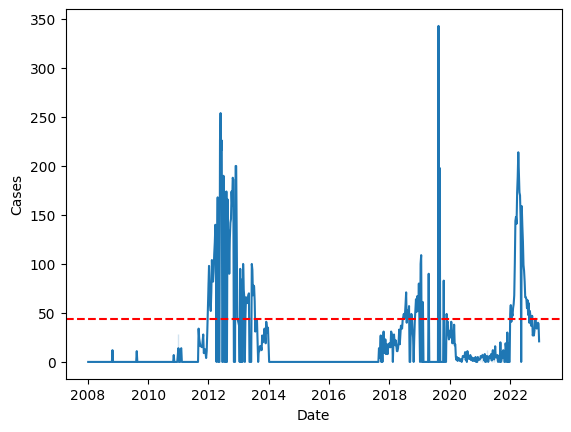

In [25]:
sns.lineplot(x="Date", y="Cases", data=zambo_dengue_df)

# Add a horizontal line for the threshold
sample_threshold = 44
plt.axhline(sample_threshold, color="red", linestyle="--", label="Threshold")
# Show the plot
plt.show()

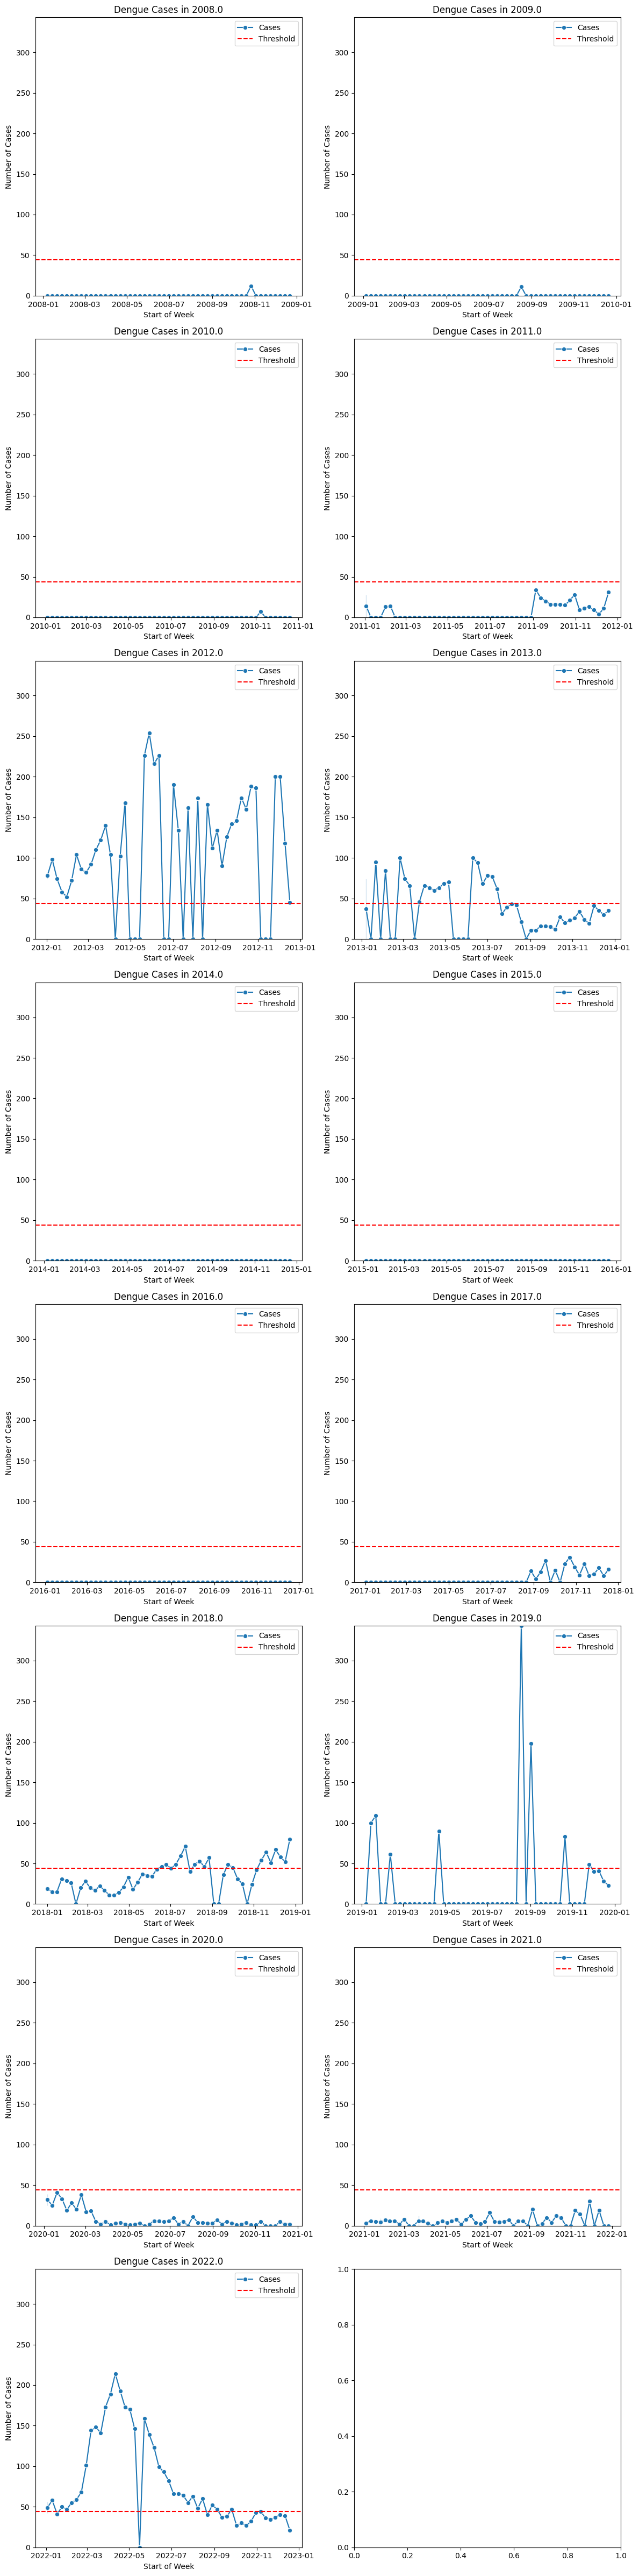

In [26]:
# Extract unique years from the 'start_of_week' column
years = zambo_dengue_df["Year"].unique()

y_min = zambo_dengue_df["Cases"].min()
y_max = zambo_dengue_df["Cases"].max()

# Calculate the number of rows and columns for subplots
num_rows = len(years) // 2 + (len(years) % 2)  # Adjust for odd number of years
num_cols = 2

# Create a single figure with subplots arranged in two columns
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 6 * num_rows))

# Flatten the axes array for ease of indexing
axes = axes.flatten()

for i, year in enumerate(years):
    ax = axes[i]
    if i >= len(years):
        ax.axis("off")  # Turn off unused subplots
        continue

    ax.set_title(f"Dengue Cases in {year}")

    # Filter the data for the current year
    year_data = zambo_dengue_df[zambo_dengue_df["Date"].dt.year == year]

    # Create a Seaborn line plot for the current year's data
    sns.lineplot(
        x="Date",
        y="Cases",
        data=year_data,
        marker="o",
        label="Cases",
        ax=ax,
    )

    # Add a horizontal line for the threshold
    ax.axhline(sample_threshold, color="red", linestyle="--", label="Threshold")
    ax.set_ylim(y_min, y_max)

    # Customize the plot
    ax.set_xlabel("Start of Week")
    ax.set_ylabel("Number of Cases")
    ax.legend()

# Adjust the layout to prevent overlap of subplots
plt.tight_layout()

# Show the combined figure with subplots
plt.show()

# Setting the definition of an outbreak

We define an outbreak as follows:

1. The **start** of an outbreak occurs when the week's cases equal to or higher than a threshold. 

    - The **threshold** is defined as the 75th percentile of weekly cases based on years when a substantial number of cases are recorded. 

2. The **end** of an outbreak occurs during the week when cases fall below the threshold for at least 2 weeks.


The chosen threshold is **44** cases.

In [46]:
top_years_list = [
    2011.0,
    2012.0,
    2013.0,
    2017.0,
    2018.0,
    2019.0,
    2020.0,
    2021.0,
    2022.0,
]
subset_zamb = zambo_dengue_df[zambo_dengue_df["Year"].isin(top_years_list)]
subset_zamb["Cases"].describe()

count    480.000000
mean      32.770833
std       50.498079
min        0.000000
25%        0.000000
50%       10.000000
75%       44.000000
max      343.000000
Name: Cases, dtype: float64

# Labeling data based on threshold definition

In [38]:
# Set your threshold value
OUTBREAK_THRESHOLD = 44

# Create a new column 'outbreak' initialized with zeros
zambo_dengue_df["outbreak"] = 0

# Track weeks satisfying the threshold, and count consecutive outbreak weeks
consecutive_weeks_below_threshold = 0
previous_outbreak = False

for index, row in zambo_dengue_df.iterrows():
    if row["Cases"] > OUTBREAK_THRESHOLD:
        consecutive_weeks_below_threshold = 0
        previous_outbreak = True
        zambo_dengue_df.at[index, "outbreak"] = 1
    else:
        # check if previous week was an outbreak
        # if yes, continue to tag current week as outbreak
        # part of observation period
        if previous_outbreak and consecutive_weeks_below_threshold < 2:
            zambo_dengue_df.at[index, "outbreak"] = 1
            consecutive_weeks_below_threshold += 1
        elif consecutive_weeks_below_threshold == 2:
            zambo_dengue_df.at[index, "outbreak"] = 0
            previous_outbreak = False
        else:
            zambo_dengue_df.at[index, "outbreak"] = 0

/tmp/ipykernel_23147/501382131.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zambo_dengue_df["outbreak"] = 0


In [39]:
zambo_dengue_df.head()

,Source,Year,Month,Week,Date,Region,PSGC_Region,Municipality,PSGC_Municipality,ICD,Disease,Cases,Claims,Deaths,Case_Type,Date_Type,outbreak,outbreak_group
36,PIDSR-DOH,2008.0,1.0,1,2008-01-07,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,"FEVER, DENGUE",0.0,NaN,NaN,Morbidity,Weekly,0,0
120,PIDSR-DOH,2008.0,1.0,2,2008-01-07,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,"FEVER, DENGUE",0.0,NaN,NaN,Morbidity,Weekly,0,0
204,PIDSR-DOH,2008.0,1.0,3,2008-01-14,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,"FEVER, DENGUE",0.0,NaN,NaN,Morbidity,Weekly,0,0
288,PIDSR-DOH,2008.0,1.0,4,2008-01-21,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,"FEVER, DENGUE",0.0,NaN,NaN,Morbidity,Weekly,0,0
372,PIDSR-DOH,2008.0,1.0,5,2008-01-28,Region IX,PH090000000,Zamboanga City,PH097332000,A90-A91,"FEVER, DENGUE",0.0,NaN,NaN,Morbidity,Weekly,0,0


In [41]:
# Cout outbreak vs non outbreak weeks
zambo_dengue_df["outbreak"].value_counts(dropna=False)

0    625
1    167
Name: outbreak, dtype: int64

In [40]:
zambo_dengue_df.to_csv(
    PROCESSED_DIR / "pidsr_city_weekly_zamboanga_labeled_v2.csv", index=False
)

## Inspect labeled data

Jumps in the lineplots can be ignored. Sudden jumps just indicate a change in the outbreak label.

In [ ]:
sns.lineplot(
    x="Date",
    y="Cases",
    data=zambo_dengue_df[(zambo_dengue_df["Year"] == 2018)],
    hue="outbreak",
    marker="o",
)

# Add a horizontal line for the threshold
plt.axhline(44, color="red", linestyle="--", label="Threshold")
# Show the plot
plt.show()

## Get Outbreaks Summary table

In [43]:
summary_city = create_outbreak_summary(zambo_dengue_df, "outbreak")
summary_city

/home/abbymoreno/lacuna-fund-climate-health/notebooks/baseline-model/../../src/model_data_prep.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tagged_df.sort_values(by=["Date"], inplace=True)
/home/abbymoreno/lacuna-fund-climate-health/notebooks/baseline-model/../../src/model_data_prep.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tagged_df["outbreak_group"] = outbreak_groups


,outbreak_group,start_date,end_date,actual_length_weeks
0,1,2012-01-02,2012-05-07,20
1,3,2012-05-21,2012-11-12,26
2,5,2012-11-26,2013-05-20,25
3,7,2013-06-10,2013-07-29,8
4,9,2018-06-18,2018-09-10,13
5,11,2018-09-24,2018-10-15,4
6,13,2018-11-12,2019-02-25,16
7,15,2019-04-22,2019-05-06,3
8,17,2019-08-19,2019-09-16,5
9,19,2019-10-21,2019-11-04,3


In [44]:
# summary_city.to_csv(LGU_DIR / "outbreaks_city_weekly_zamboanga_v1.csv", index=False)